In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# installing libraries
!pip install qiskit
!pip install pylatexenc
!python -m pip install -U matplotlib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.8/943.8 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 22.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.3 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=b32eee64b424301bb73e45986b727fab0d4e70b0d0d054f734b56ff26710bcc9
  Stored in directory: /root/.cache/pip/wheels/de/e2/bc/795993e2fc0f60127e9f418d52ba163246c910e81a53e859f4
Successfully built qiskit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.2 MB/s eta 0:00:00a 0

In [2]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 37.8 MB/s eta 0:00:0000:0100:01


In [3]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from math import pi
from qiskit import *  
import tensorflow as tf
from qutip import *
from sklearn.decomposition import PCA
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from qiskit import IBMQ

# Set this to the backend you are choosing for qiskit.
# For real IBMQ Evaluation, use a provider
backend = Aer.get_backend('qasm_simulator')

In [4]:
# --------------------------------------------------
# The following section we prepare the MNIST dataset
# and normalize the dataset to be in the bound 0-1
# Following this, the data is transformed using the 
# PCA algorithm down to k dimensions 
# --------------------------------------------------
test_images,test_labels = tf.keras.datasets.mnist.load_data()
train_images = test_images[0].reshape(60000,784)
train_labels = test_images[1]
labels = test_images[1]
train_images = train_images/255

# --------------------------------------------------
# ---------------- PCA Section ---------------------
# --------------------------------------------------
k=2
pca = PCA(n_components=k)
pca.fit(train_images)
pca_data = pca.transform(train_images)[:10000]
train_labels = train_labels[:10000]
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()

# --------------------------------------------------
# -----  Transform PCA data to rotations ----------
# --------------------------------------------------
pca_data_rot= 2*np.arcsin(np.sqrt(pca_data))
valid_labels = None
valid_labels = train_labels==9
valid_labels = train_labels == 3 

pca_data_rot = pca_data_rot[valid_labels]
pca_data = pca_data[valid_labels]

print(f"The Total Explained Variance of {k} Dimensions is {sum(pca.explained_variance_ratio_).round(3)}")

# --------------------------------------------------
# Define a function that can take in PCA'ed data and return an image
# --------------------------------------------------
def descale_points(d_point,scales=pca_descaler,tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:,col] *= scales[col][1]
        d_point[:,col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction

11501568/11490434 [==============================] - 0s 0us/step
The Total Explained Variance of 2 Dimensions is 0.168


In [5]:
#All functions needed for the functionality of the circuit simulation
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      dp = np.array((predictions[i] * 127.5) + 127.5).astype('uint8')
      plt.imshow(dp)
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
    

    
def ran_ang():
    #return np.pi/2
    return np.random.rand()*np.pi

def single_qubit_unitary(circ_ident,qubit_index,values):
    circ_ident.ry(values[0],qubit_index)

def dual_qubit_unitary(circ_ident,qubit_1,qubit_2,values):
    circ_ident.ryy(values[0],qubit_1,qubit_2)

def controlled_dual_qubit_unitary(circ_ident,control_qubit,act_qubit,values):
    circ_ident.cry(values[0],control_qubit,act_qubit)
    #circ_ident.cry(values[0],act_qubit,control_qubit)
    
def traditional_learning_layer(circ_ident,num_qubits,values,style="Dual",qubit_start=1,qubit_end=5):
    if style == "Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
    elif style =="Single":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
    elif style=="Controlled-Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
        for qub in np.arange(qubit_start,qubit_end-1):
            controlled_dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+"--"+str(qub+1)])

def data_loading_circuit(circ_ident,num_qubits,values,qubit_start=1,qubit_end=5):
    k = 0
    for qub in np.arange(qubit_start,qubit_end):
        circ_ident.ry(values[k],qub)
        k += 1

def swap_test(circ_ident,num_qubits):
    num_swap = num_qubits//2
    for i in range(num_swap):
        circ_ident.cswap(0,i+1,i+num_swap+1)
    circ_ident.h(0)
    circ_ident.measure(0,0)
        
def init_random_variables(q,style):
    trainable_variables = {}
    if style=="Single":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
    elif style=="Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
    elif style=="Controlled-Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
                trainable_variables[str(i)+"--"+str(i+1)] = [ran_ang()]
    return trainable_variables
    
def get_probabilities(circ,counts=5000):
    job = execute(circ, backend, shots=counts)
    results = job.result().get_counts(circ)
    try:
        prob = results['0']/(results['1']+results['0'])
        prob = (prob-0.5)
        if prob <= 0.005:
            prob = 0.005
        else:
            prob = prob*2
    except:
        prob = 1
    return prob
        
# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p,yreal,trimming):
    if yreal == 0:
        return -np.log(p)
        #return 1-p
    elif yreal == 1:
        return -np.log(1-p)
        #return p
    
def generator_cost_function(p):
    return -np.log(p)

def update_weights(init_value,lr,grad):
    while lr*grad > 2*np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr*grad
    new_value = init_value
    print("Updating with a new value of " + str(weight_update))
    if new_value-weight_update > 2*np.pi:
        new_value = (new_value-weight_update) - 2*np.pi
    elif new_value-weight_update < 0:
        new_value = (new_value-weight_update) + 2*np.pi
    else:
        new_value = new_value - weight_update
    return new_value 

# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p,yreal,trimming):
    if yreal == 0:
        return -np.log(p)
        #return 1-p
    elif yreal == 1:
        return -np.log(1-p)
        #return p
    
def generator_cost_function(p):
    return -np.log(p)

def update_weights(init_value,lr,grad):
    while lr*grad > 2*np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr*grad
    new_value = init_value
    print("Updating with a new value of " + str(weight_update))
    if new_value-weight_update > 2*np.pi:
        new_value = (new_value-weight_update) - 2*np.pi
    elif new_value-weight_update < 0:
        new_value = (new_value-weight_update) + 2*np.pi
    else:
        new_value = new_value - weight_update
    return new_value

In [6]:
# ------------------------------------------------------------------------------------
# We treat the first n qubits are the discriminators state. n is always defined as the
# integer division floor of the qubit count.
# This is due to the fact that a state will always be k qubits, therefore the 
# number of total qubits must be 2k+1. 2k as we need k for the disc, and k to represent
# either the other learned quantum state, or k to represent a data point
# then +1 to perform the SWAP test. Therefore, we know that we will always end up
# with an odd number of qubits. We take the floor to solve for k. 1st k represents 
# disc, 2nd k represents the "loaded" state be it gen or real data
# ------------------------------------------------------------------------------------
# Use different function calls to represent training a GENERATOR or training a DISCRIMINATOR
# ------------------------------------------------------------------------------------
# THIS SECTION IS FOR THE ONLINE GENERATION OF QUANTUM CIRCUITS

def disc_fake_training_circuit(trainable_variables,key,key_value,diff=False,fwd_diff = False,Sample=False):
    if Sample:
        z = q//2
        circ = QuantumCircuit(q,z)
    else:
        circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] += par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=q//2 +1,qubit_end=q)
    if Sample:
        for qub in range(q//2):
            circ.measure(q//2 + 1 + qub,qub)
    else:
        swap_test(circ,q)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] -= par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] += par_shift
    return circ

def disc_real_training_circuit(training_variables,data,key,key_value,diff,fwd_diff):
    circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] += par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,training_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    data_loading_circuit(circ,q,data,qubit_start=q//2 +1,qubit_end=q)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] -= par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] += par_shift
    swap_test(circ,q)
    return circ

def generate_kl_divergence_hist(actual_data, epoch_results_data):
    plt.clf() # clears current figure
    sns.set()
    kl_div_vec = []
    for kl_dim in range(actual_data.shape[1]):
        kl_div = kl_divergence(actual_data[:,kl_dim],epoch_results_data[:,kl_dim])
        kl_div_vec.append(kl_div)
    return kl_div_vec

def bin_data(dataset):
    bins = np.zeros(10)
    for point in dataset:
        indx = int(str(point).split('.')[-1][0]) # The shittest way imaginable to extract the first val aft decimal
        bins[indx] +=1  
    bins /= sum(bins)
    return bins

def kl_divergence(p_dist, q_dist):
    p = bin_data(p_dist)
    q = bin_data(q_dist)
    kldiv = 0
    for p_point,q_point in zip(p,q):
        kldiv += (np.sqrt(p_point) - np.sqrt(q_point))**2
    kldiv = (1/np.sqrt(2))*kldiv**0.5 
    return kldiv
    #return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))  # ?... are we confident in this... 

    
# Checkpointing code
def save_variables(var_dict,epoch):
    with open(f"Epoch-{epoch}-Variables-numbers-9",'w') as file:
        file.write(str(train_var))

Starting Training
--------------------
Generator Loss: 0.2549538456094064
Discriminator Loss: 2.41533282708589
--------------------
[0.47055164870703, 0.3680423122302179]
[0.41929698046862396]
Epoch 1 Generated Images


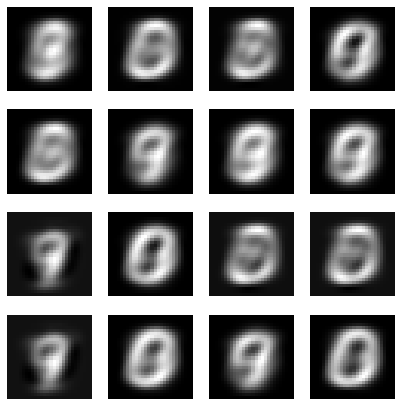

Generator Loss: 0.23066404248181413
Discriminator Loss: 2.3226898459255794
--------------------
[0.5033006598423948, 0.38872304711756384]
[0.41929698046862396, 0.4460118534799793]
Epoch 2 Generated Images


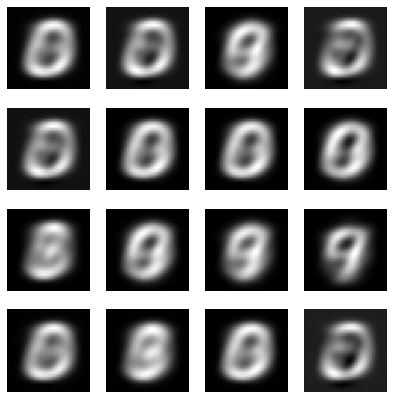

Generator Loss: 0.22553447829612383
Discriminator Loss: 2.3190576232234674
--------------------
[0.4711047451763898, 0.38195636359751267]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512]
Epoch 3 Generated Images


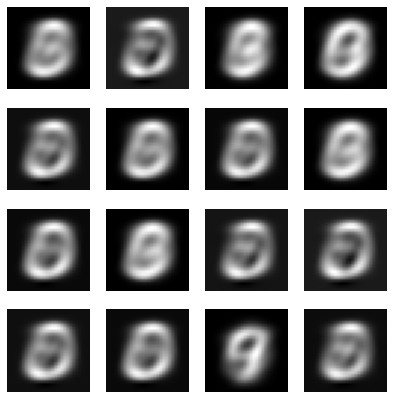

Generator Loss: 0.2315350461778289
Discriminator Loss: 2.1180260412598995
--------------------
[0.4585086382197691, 0.3800607481661521]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606]
Epoch 4 Generated Images


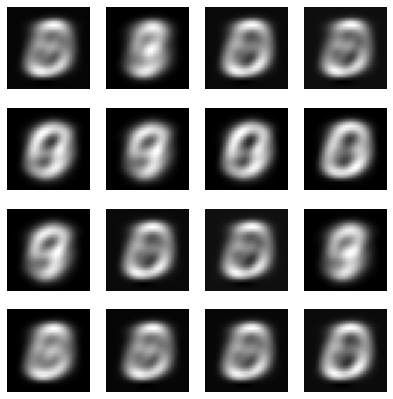

Generator Loss: 0.23899143812703638
Discriminator Loss: 2.108506258001933
--------------------
[0.45640193492246306, 0.36601136373813575]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994]
Epoch 5 Generated Images


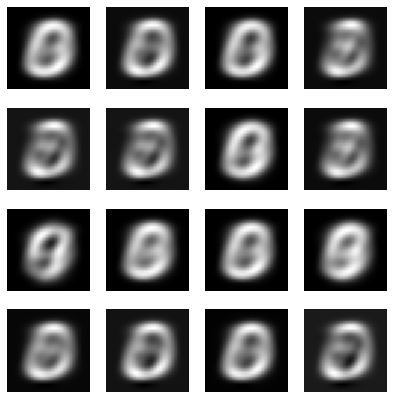

Generator Loss: 0.2460789539197339
Discriminator Loss: 2.0547255147294363
--------------------
[0.46099968851196843, 0.32245980110495764]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463]
Epoch 6 Generated Images


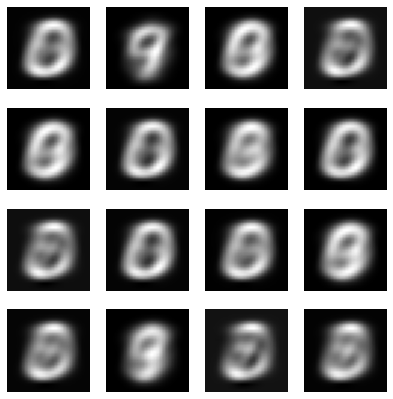

Generator Loss: 0.2566274152035007
Discriminator Loss: 1.9991580260797788
--------------------
[0.4765345610924817, 0.3664698909825085]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951]
Epoch 7 Generated Images


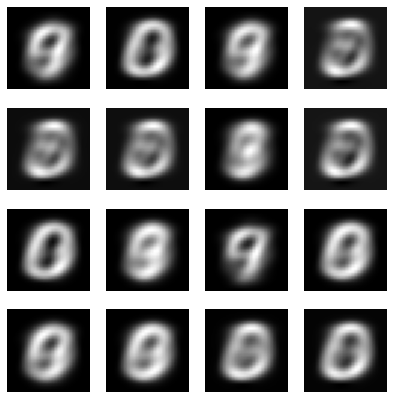

Generator Loss: 0.2607317542450608
Discriminator Loss: 1.942509059323542
--------------------
[0.4146830411264364, 0.39372148037927396]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515]
Epoch 8 Generated Images


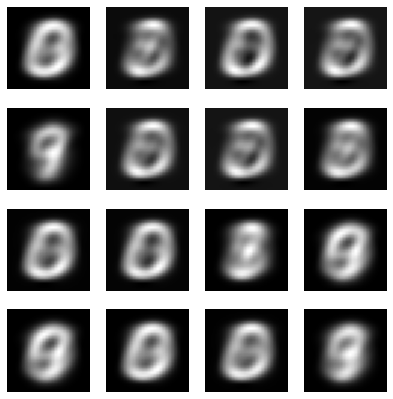

Generator Loss: 0.26732305939608003
Discriminator Loss: 1.8463589387839894
--------------------
[0.3925185503177601, 0.3554494931951798]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994]
Epoch 9 Generated Images


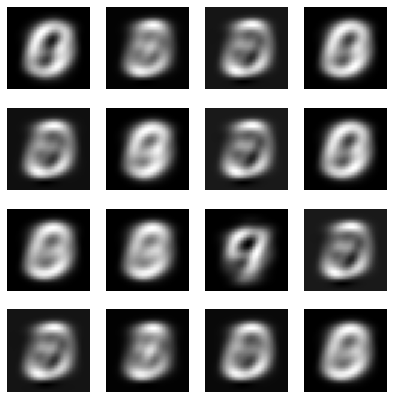

Generator Loss: 0.2726048807854344
Discriminator Loss: 1.9063055096111636
--------------------
[0.3899306122509012, 0.3475053968512727]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694]
Epoch 10 Generated Images


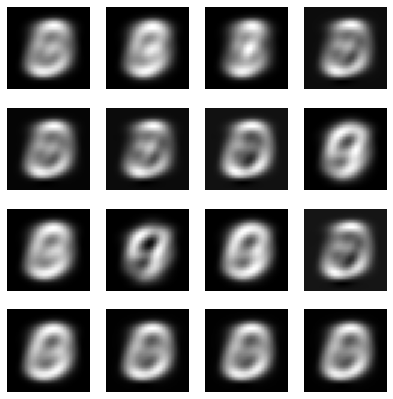

Generator Loss: 0.2788215484682221
Discriminator Loss: 1.904555560388503
--------------------
[0.38616943654662306, 0.3612021444583734]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982]
Epoch 11 Generated Images


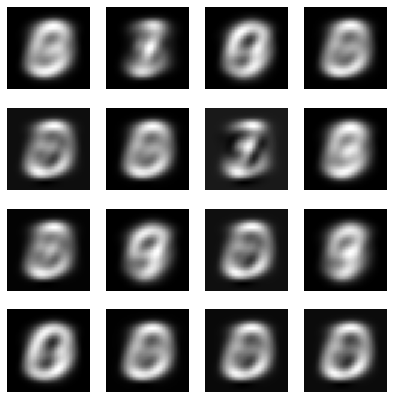

Generator Loss: 0.28083853543687365
Discriminator Loss: 1.8095839455556115
--------------------
[0.35777651786507814, 0.36712559538684597]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205]
Epoch 12 Generated Images


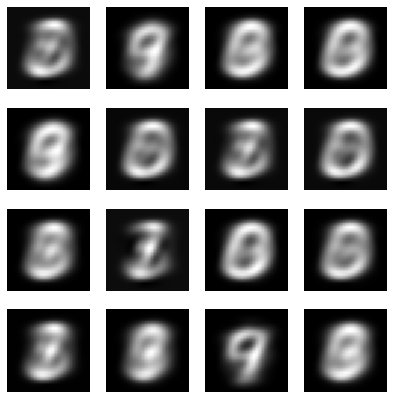

Generator Loss: 0.2833667993656527
Discriminator Loss: 1.8332877130836711
--------------------
[0.33935510162290305, 0.36397805889810486]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396]
Epoch 13 Generated Images


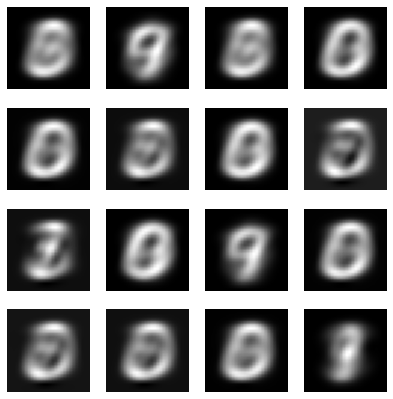

Generator Loss: 0.2860897827685282
Discriminator Loss: 1.7112226067460425
--------------------
[0.3228315659247349, 0.3943666959784695]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223]
Epoch 14 Generated Images


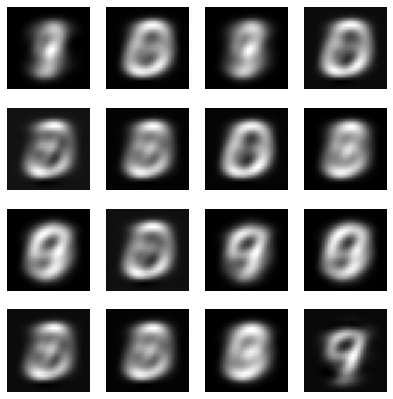

Generator Loss: 0.28949062975114975
Discriminator Loss: 1.7585274216202145
--------------------
[0.32233660378639317, 0.3640999247733156]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436]
Epoch 15 Generated Images


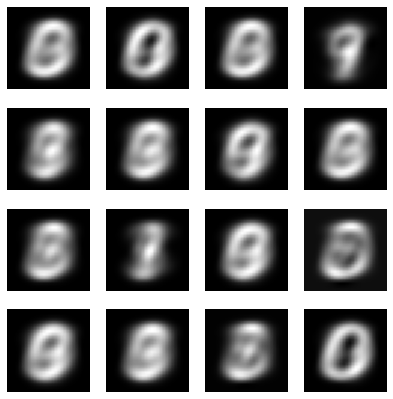

Generator Loss: 0.2908771374707752
Discriminator Loss: 1.7325126243458056
--------------------
[0.26898226964020033, 0.3570356375126677]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434]
Epoch 16 Generated Images


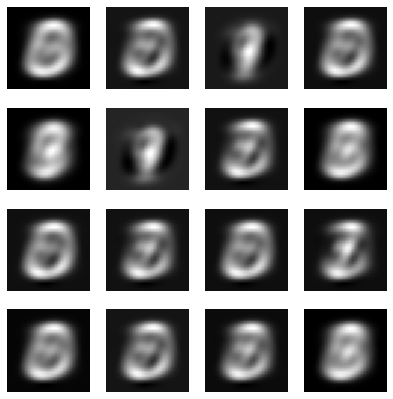

Generator Loss: 0.29104117092477017
Discriminator Loss: 1.687658081939754
--------------------
[0.2450098158587853, 0.38304804249767277]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905]
Epoch 17 Generated Images


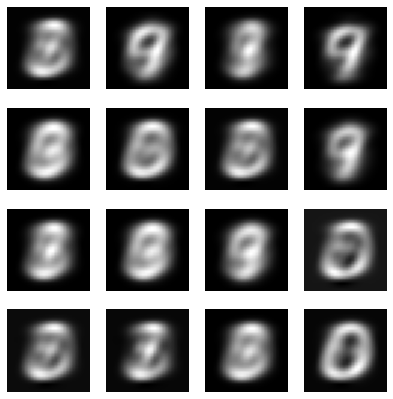

Generator Loss: 0.2925697217269293
Discriminator Loss: 1.7370731217612256
--------------------
[0.25552152046702786, 0.3729721865958541]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441]
Epoch 18 Generated Images


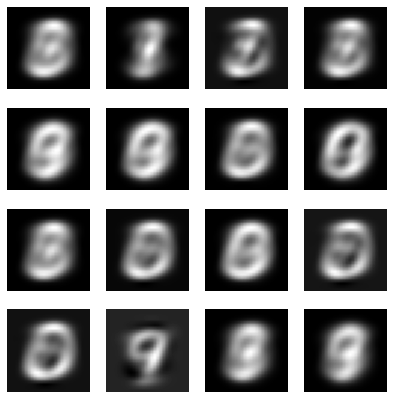

Generator Loss: 0.29210505862899344
Discriminator Loss: 1.7712700190252066
--------------------
[0.2198497500173957, 0.40587293097324656]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211]
Epoch 19 Generated Images


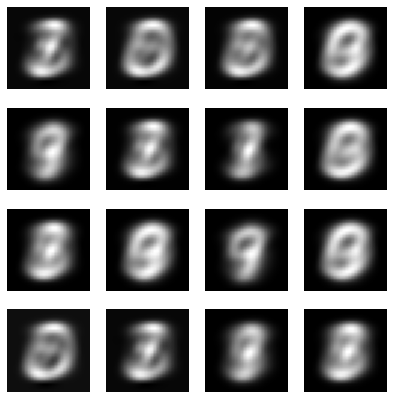

Generator Loss: 0.2890202676286709
Discriminator Loss: 1.7615425534936227
--------------------
[0.2276538597712448, 0.385243786391617]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309]
Epoch 20 Generated Images


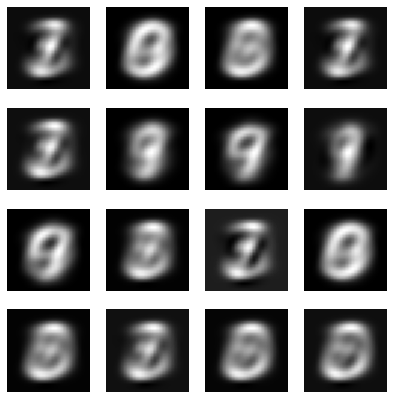

Generator Loss: 0.2906970170580953
Discriminator Loss: 1.6528031382271373
--------------------
[0.19344510956406588, 0.4062798990201043]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851]
Epoch 21 Generated Images


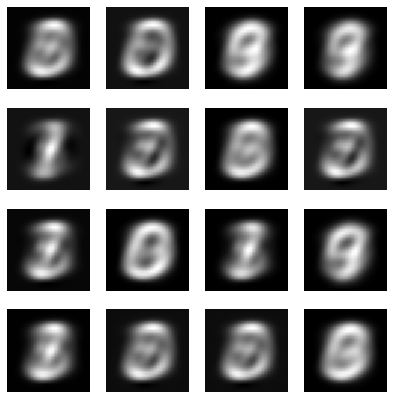

Generator Loss: 0.29015147121489654
Discriminator Loss: 1.6793111713483588
--------------------
[0.16174240803851808, 0.37799856702441187]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465]
Epoch 22 Generated Images


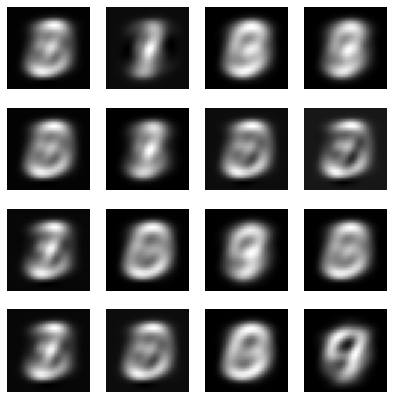

Generator Loss: 0.28801184696772075
Discriminator Loss: 1.7022639802011508
--------------------
[0.11797909928005462, 0.3832437120917406]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757]
Epoch 23 Generated Images


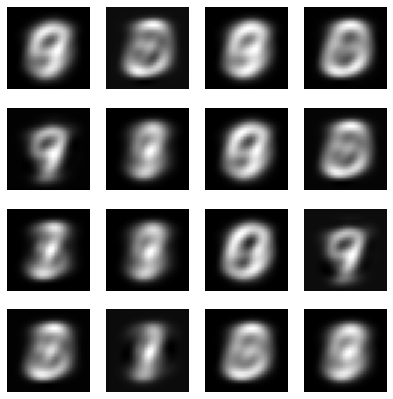

Generator Loss: 0.28458172305723983
Discriminator Loss: 1.7356371652979796
--------------------
[0.17062283778346402, 0.3792751950047005]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226]
Epoch 24 Generated Images


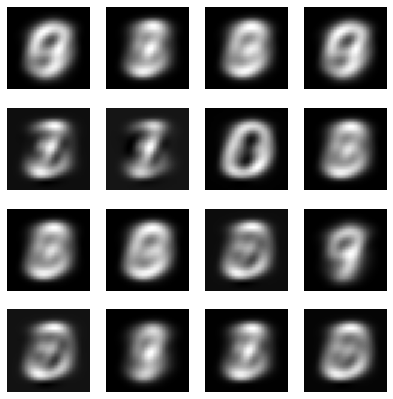

Generator Loss: 0.28272509747771485
Discriminator Loss: 1.6304295022661932
--------------------
[0.16721493780509655, 0.38049042853769843]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975]
Epoch 25 Generated Images


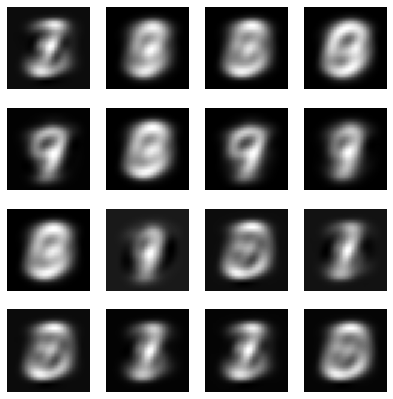

Generator Loss: 0.2829224342612271
Discriminator Loss: 1.621601186039908
--------------------
[0.12982803522834466, 0.37244579945396006]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234]
Epoch 26 Generated Images


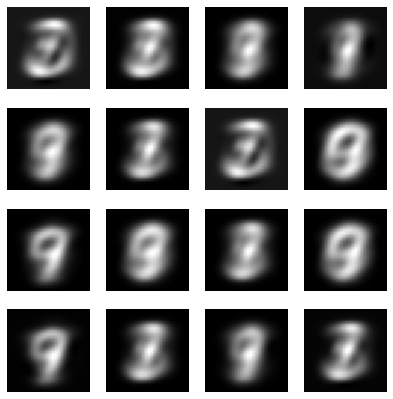

Generator Loss: 0.2792571603875352
Discriminator Loss: 1.6826126586401866
--------------------
[0.11424295465914316, 0.37466433363594315]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317]
Epoch 27 Generated Images


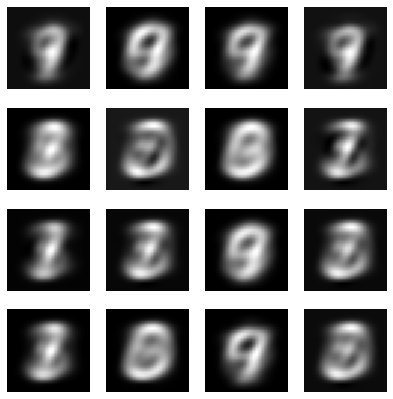

Generator Loss: 0.2774555697053842
Discriminator Loss: 1.660512283418707
--------------------
[0.10621896515922095, 0.38093029458922323]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221]
Epoch 28 Generated Images


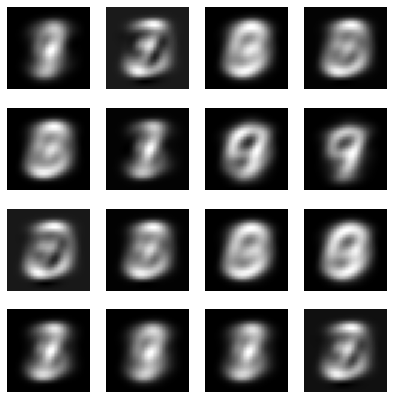

Generator Loss: 0.2740719844039976
Discriminator Loss: 1.7502017965853234
--------------------
[0.09703047424263858, 0.368468880538359]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988]
Epoch 29 Generated Images


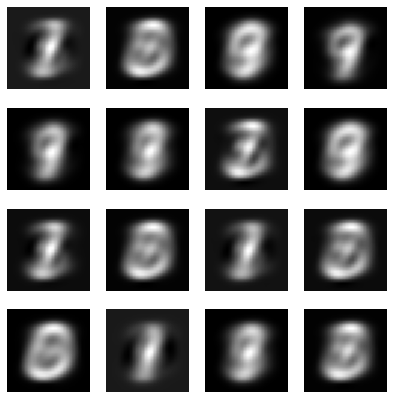

Generator Loss: 0.2712431269642395
Discriminator Loss: 1.6759658244314266
--------------------
[0.06827918350861928, 0.38173551678097845]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886]
Epoch 30 Generated Images


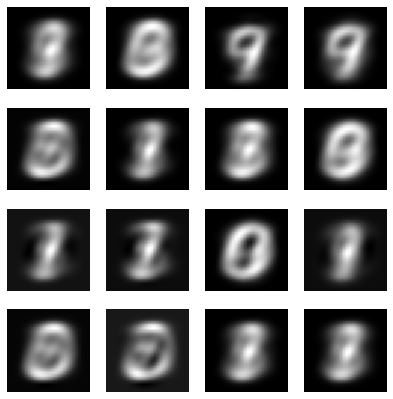

Generator Loss: 0.2701683207097751
Discriminator Loss: 1.7307056124872886
--------------------
[0.0775245659905844, 0.35853943621672413]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425]
Epoch 31 Generated Images


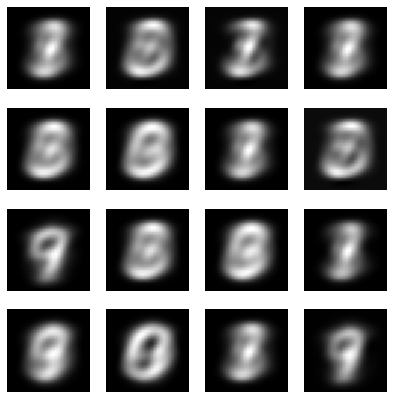

Generator Loss: 0.26741437550228486
Discriminator Loss: 1.6973296768510375
--------------------
[0.03712062082592637, 0.354592922036117]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168]
Epoch 32 Generated Images


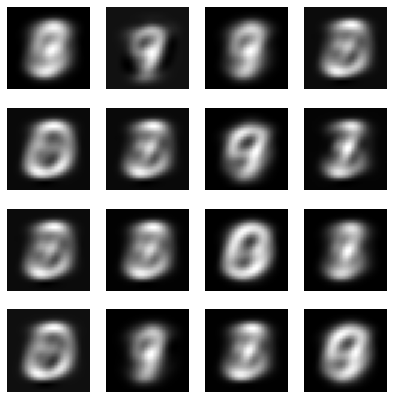

Generator Loss: 0.26305311785485747
Discriminator Loss: 1.6508767638381154
--------------------
[0.12728690545669213, 0.36029807981640577]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895]
Epoch 33 Generated Images


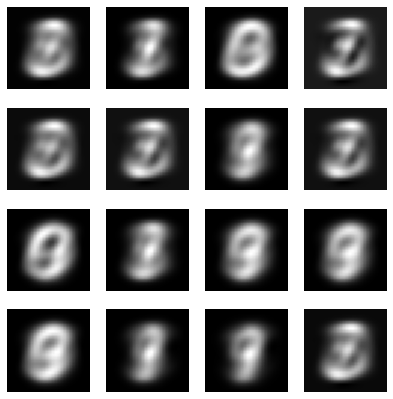

Generator Loss: 0.2623517509287214
Discriminator Loss: 1.7182532781082238
--------------------
[0.07684931752725135, 0.3617979861731887]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022]
Epoch 34 Generated Images


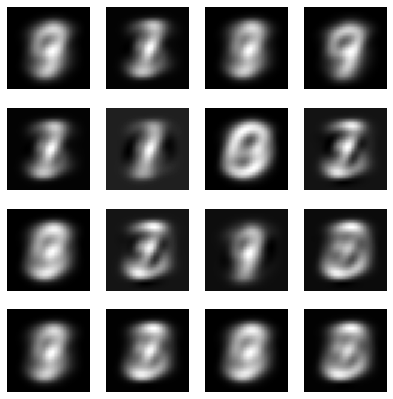

Generator Loss: 0.26043287838873996
Discriminator Loss: 1.7243317259154578
--------------------
[0.07700285045836165, 0.3559451854914644]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303]
Epoch 35 Generated Images


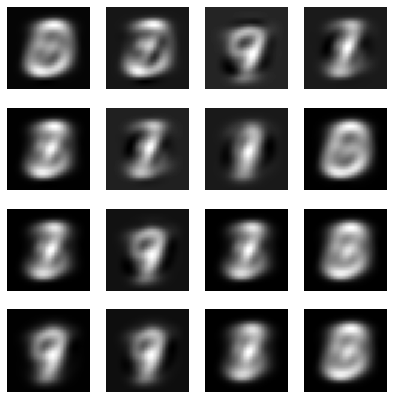

Generator Loss: 0.2562801056787147
Discriminator Loss: 1.7618341322268356
--------------------
[0.10693727333198988, 0.35345052135646465]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727]
Epoch 36 Generated Images


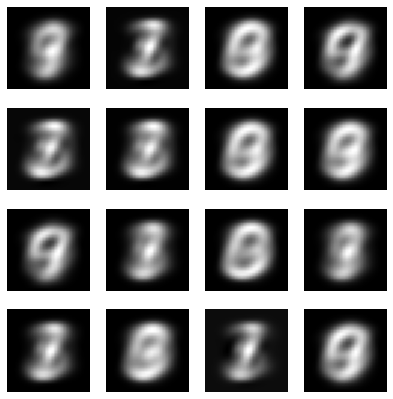

Generator Loss: 0.25374159558201104
Discriminator Loss: 1.7793554382893078
--------------------
[0.09970242021702581, 0.3295465307127813]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354]
Epoch 37 Generated Images


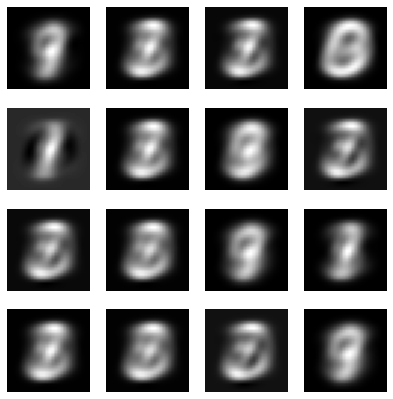

Generator Loss: 0.2531842055920182
Discriminator Loss: 1.7594890070559133
--------------------
[0.12215968216817481, 0.33489284184390355]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918]
Epoch 38 Generated Images


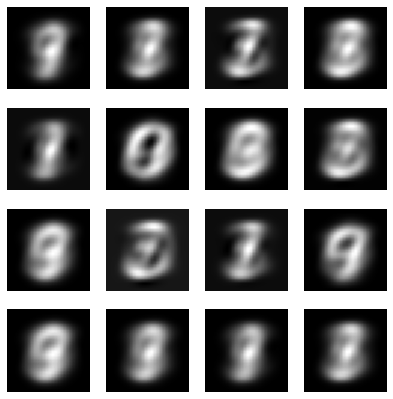

Generator Loss: 0.24776913396318756
Discriminator Loss: 1.7440762031586405
--------------------
[0.11979702452061013, 0.3266278021879792]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468]
Epoch 39 Generated Images


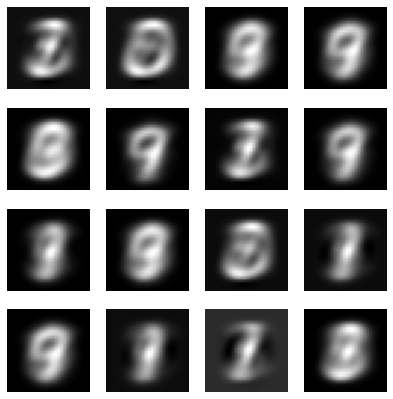

Generator Loss: 0.24524137191776718
Discriminator Loss: 1.734435309124777
--------------------
[0.1294960268041593, 0.31302929198898105]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702]
Epoch 40 Generated Images


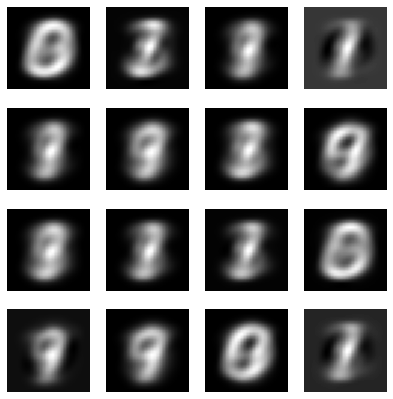

Generator Loss: 0.2440696277620962
Discriminator Loss: 1.7253921214139072
--------------------
[0.13073159554959177, 0.324101974067574]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829]
Epoch 41 Generated Images


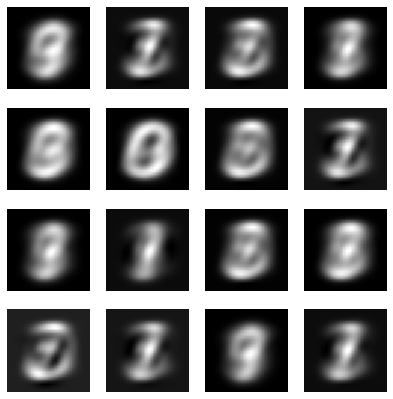

Generator Loss: 0.23891069731593947
Discriminator Loss: 1.7409188372766882
--------------------
[0.17937980796449746, 0.3064095704484498]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736]
Epoch

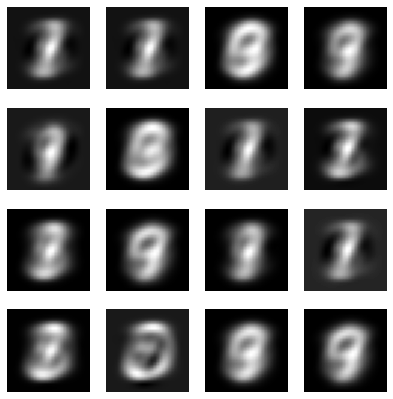

Generator Loss: 0.23799626459715906
Discriminator Loss: 1.7619822830670246
--------------------
[0.1947770570601472, 0.3506468536816049]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

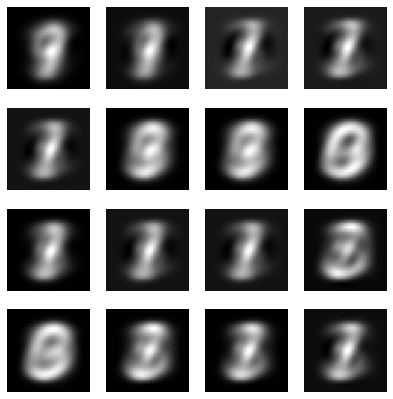

Generator Loss: 0.23499425542069904
Discriminator Loss: 1.7247966889826098
--------------------
[0.20578955855852477, 0.3044638878998926]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

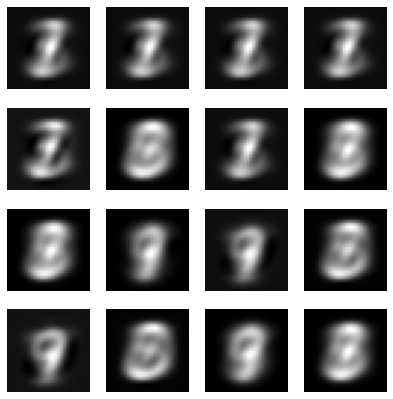

Generator Loss: 0.23081350362564682
Discriminator Loss: 1.786724167663515
--------------------
[0.20216832152608966, 0.2985732981809251]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

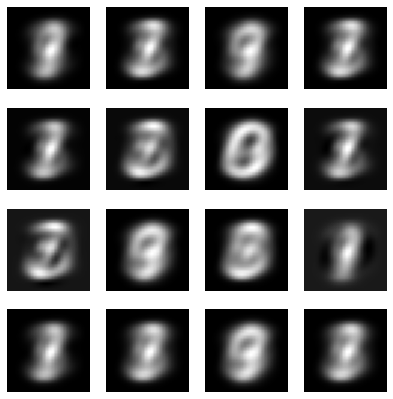

Generator Loss: 0.22878974358363552
Discriminator Loss: 1.8348079405092017
--------------------
[0.2011222284117696, 0.3492259833544166]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

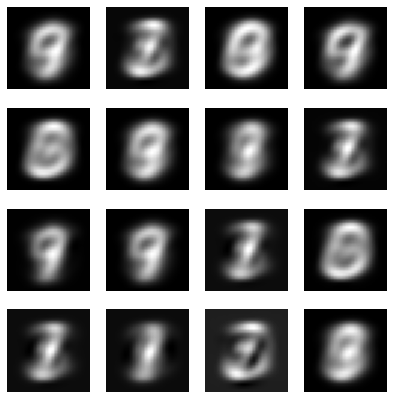

Generator Loss: 0.22548573179261946
Discriminator Loss: 1.8305056198039706
--------------------
[0.21973842173515895, 0.27982316111973365]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

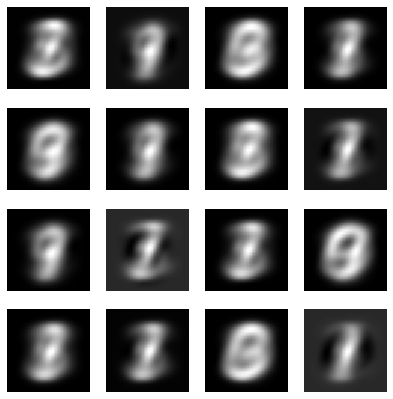

Generator Loss: 0.22148792091676453
Discriminator Loss: 1.7774457608762821
--------------------
[0.2071619342623487, 0.29471251777634294]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

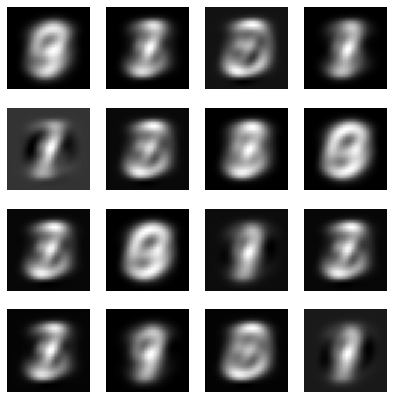

Generator Loss: 0.22043353361125467
Discriminator Loss: 1.720854059808281
--------------------
[0.2397136480872448, 0.27235791477268406]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

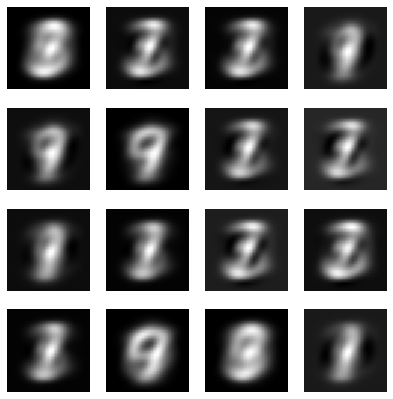

Generator Loss: 0.21821520325287172
Discriminator Loss: 1.8266391542926805
--------------------
[0.23885430895972298, 0.3014217796020668]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

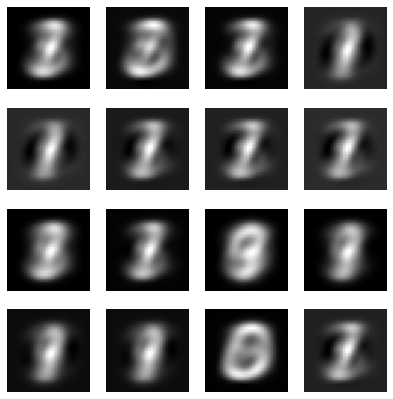

Generator Loss: 0.2132284259661289
Discriminator Loss: 1.8753470124135856
--------------------
[0.25994094934444534, 0.29043474651387335]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

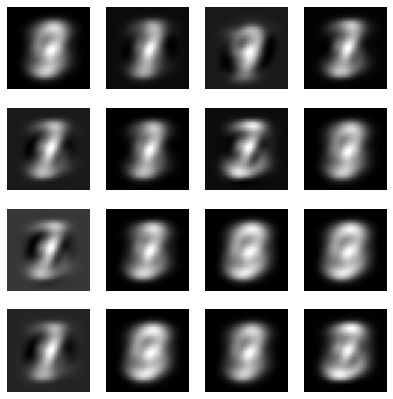

Generator Loss: 0.2125349289517994
Discriminator Loss: 1.867840833393448
--------------------
[0.24659707707925402, 0.32180601032444217]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

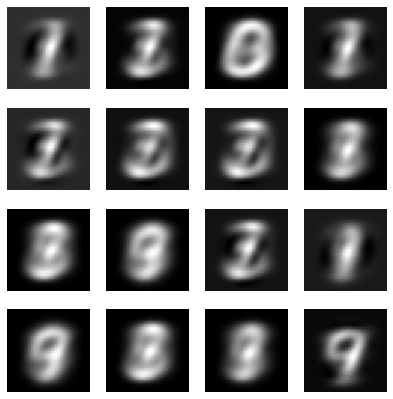

Generator Loss: 0.20782394154794004
Discriminator Loss: 1.886156306256906
--------------------
[0.30609373127518325, 0.28901488679954085]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

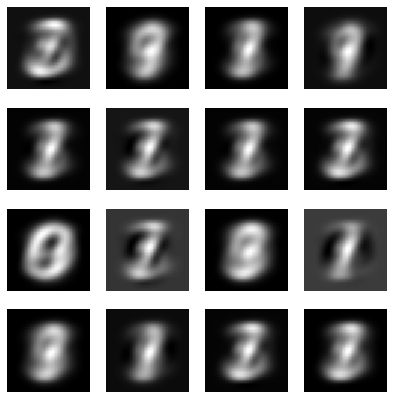

Generator Loss: 0.2049952326748556
Discriminator Loss: 1.9147138532869297
--------------------
[0.26263749542032583, 0.2851934160556819]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

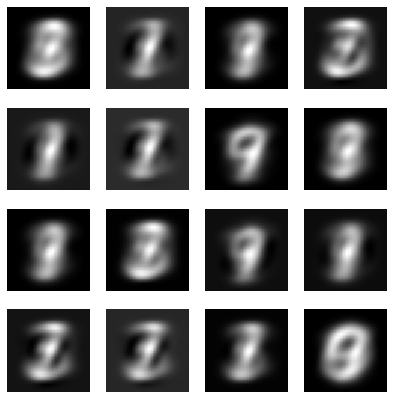

Generator Loss: 0.20220580346680114
Discriminator Loss: 1.8752489100677134
--------------------
[0.28362002570477207, 0.29197861571552414]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

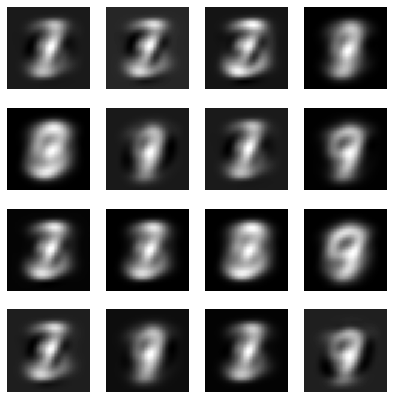

Generator Loss: 0.20017903314447197
Discriminator Loss: 1.9089334903714301
--------------------
[0.28317029339713273, 0.25532083941222705]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

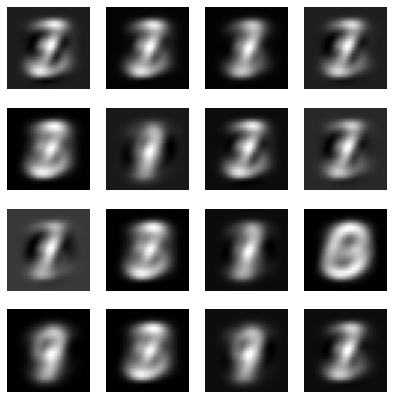

Generator Loss: 0.19920768304785336
Discriminator Loss: 1.8676077856719882
--------------------
[0.2976199317394736, 0.24294530845278434]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

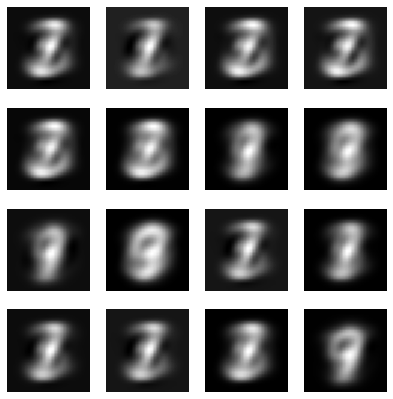

Generator Loss: 0.19607101136928196
Discriminator Loss: 1.9286387225466657
--------------------
[0.31652373040049997, 0.2593017833763352]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

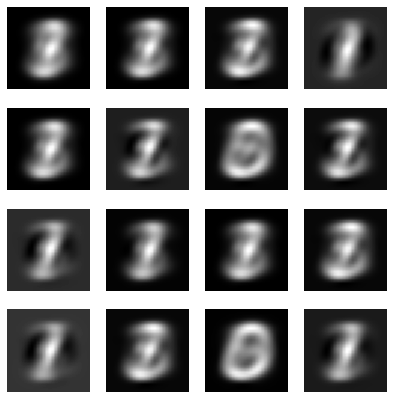

Generator Loss: 0.192606385811527
Discriminator Loss: 1.9734862589310276
--------------------
[0.31087737471743654, 0.25757914801402015]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

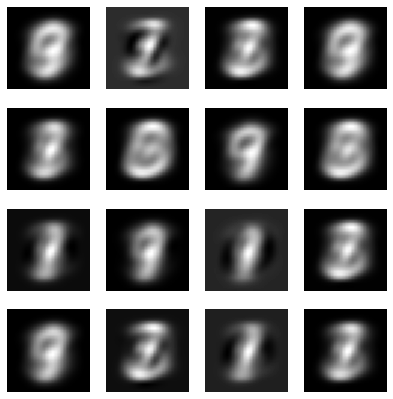

Generator Loss: 0.19056043623587043
Discriminator Loss: 1.90939339600172
--------------------
[0.3427927209354981, 0.2507440334097719]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272711

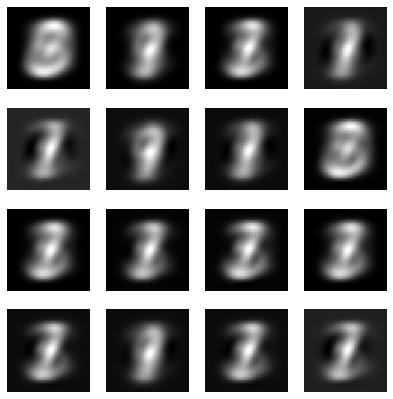

Generator Loss: 0.18801232493991007
Discriminator Loss: 1.9946063976349524
--------------------
[0.3258636717624104, 0.21940641274549383]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

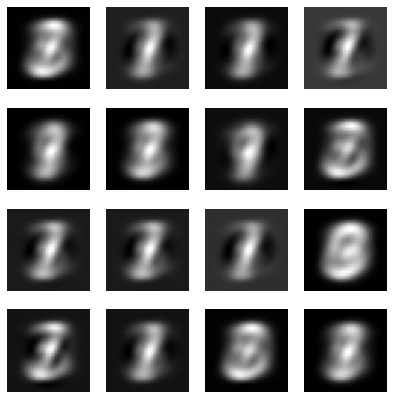

Generator Loss: 0.18402206370149
Discriminator Loss: 1.956640150172365
--------------------
[0.29071176881521943, 0.25485873292423133]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272711

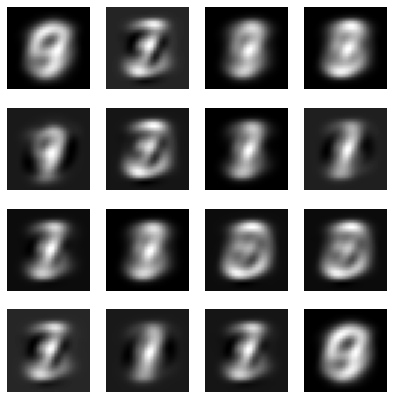

Generator Loss: 0.18274100865357495
Discriminator Loss: 1.927193287460026
--------------------
[0.33964159397673416, 0.2305961534590622]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

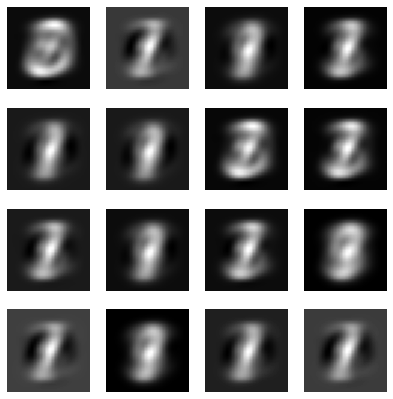

Generator Loss: 0.17983782397268386
Discriminator Loss: 2.0715419458103588
--------------------
[0.35346461579373734, 0.223852851243999]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

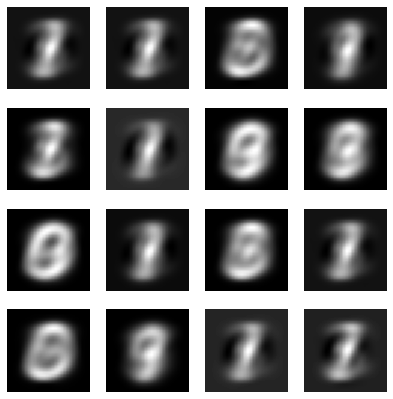

Generator Loss: 0.17818244701309355
Discriminator Loss: 2.023445403020077
--------------------
[0.33484028502032803, 0.23157448565574965]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

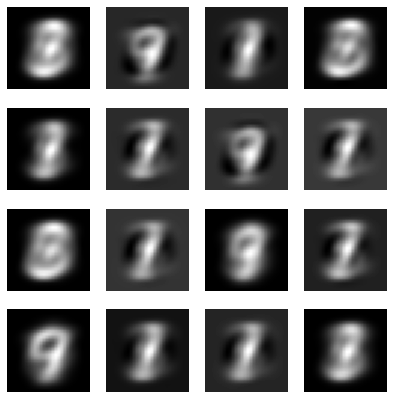

Generator Loss: 0.1737102026107202
Discriminator Loss: 2.0367315385699856
--------------------
[0.37270756075408956, 0.23212477130186226]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

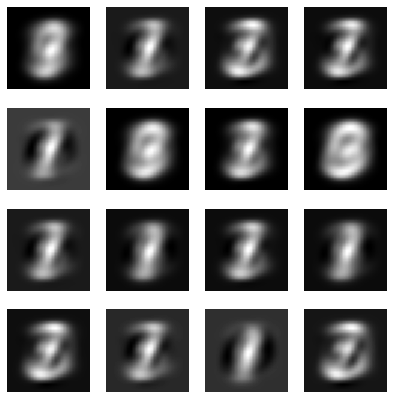

Generator Loss: 0.17283236798061974
Discriminator Loss: 2.0180680238854216
--------------------
[0.32750769226393306, 0.23246077235408746]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

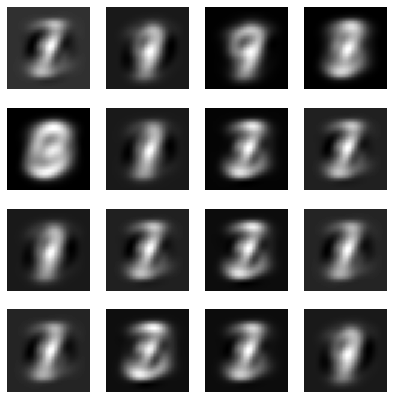

Generator Loss: 0.17111508559843974
Discriminator Loss: 2.058010123936237
--------------------
[0.3523058026176646, 0.21033282205415957]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

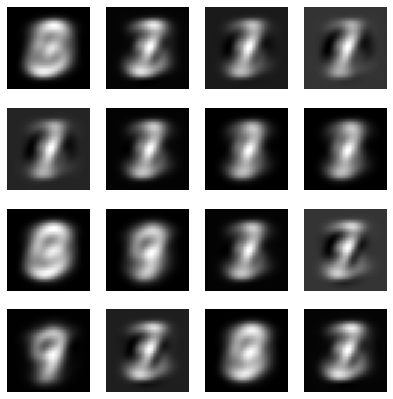

Generator Loss: 0.16807444803990262
Discriminator Loss: 2.0012368297784504
--------------------
[0.37445764838074386, 0.1976307453194306]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

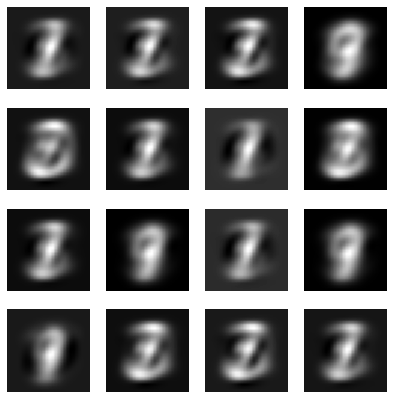

Generator Loss: 0.16681410701066401
Discriminator Loss: 1.978763973926392
--------------------
[0.37960025468172814, 0.2299877981371908]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

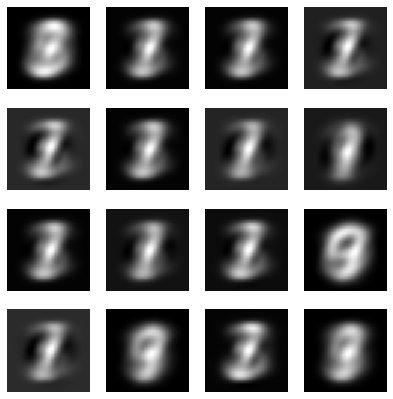

Generator Loss: 0.16400978584431333
Discriminator Loss: 2.0412305689120678
--------------------
[0.39450057855637183, 0.20507657950195082]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

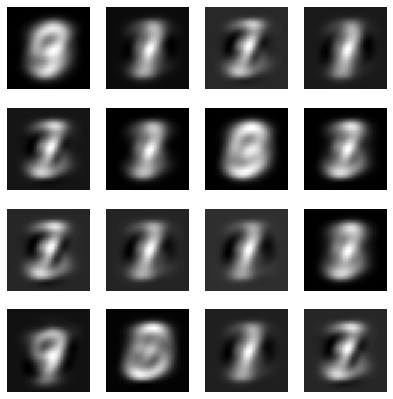

Generator Loss: 0.16032271315495938
Discriminator Loss: 2.043302495063963
--------------------
[0.35930485005815793, 0.2031677245835815]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

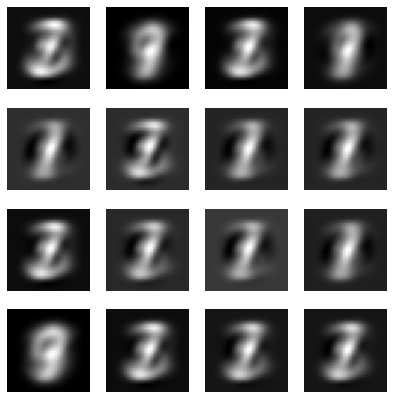

Generator Loss: 0.15938248596188703
Discriminator Loss: 2.110445227262754
--------------------
[0.37025046485183466, 0.20037242473207864]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

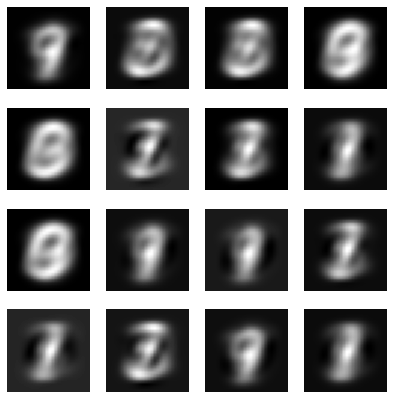

Generator Loss: 0.15491474184799997
Discriminator Loss: 2.1774944232543945
--------------------
[0.3821258803272852, 0.21699394482449727]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

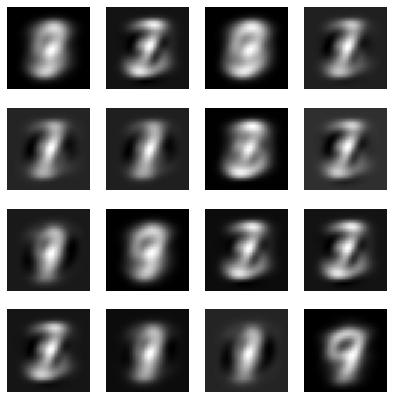

Generator Loss: 0.15430226981174952
Discriminator Loss: 2.082315427336051
--------------------
[0.3739461214924089, 0.1950142268251884]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

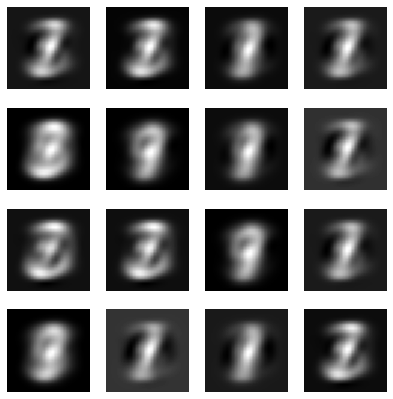

Generator Loss: 0.15265489118077105
Discriminator Loss: 1.984660956631516
--------------------
[0.37978268104795293, 0.18180895418614743]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

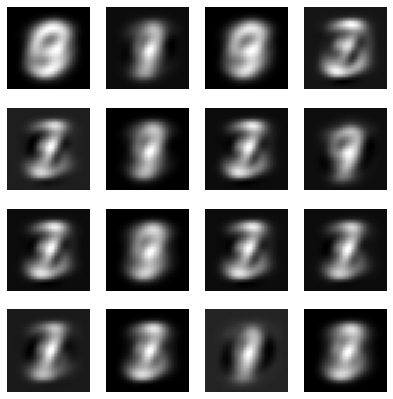

Generator Loss: 0.14998013341465583
Discriminator Loss: 2.100330198492642
--------------------
[0.4027485843294962, 0.1743026337698864]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

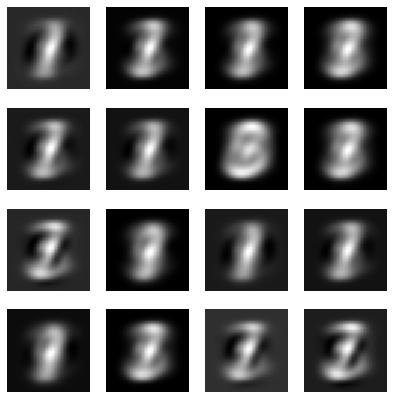

Generator Loss: 0.14928843410435713
Discriminator Loss: 2.077230867022677
--------------------
[0.3787063456262396, 0.1884243303729178]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

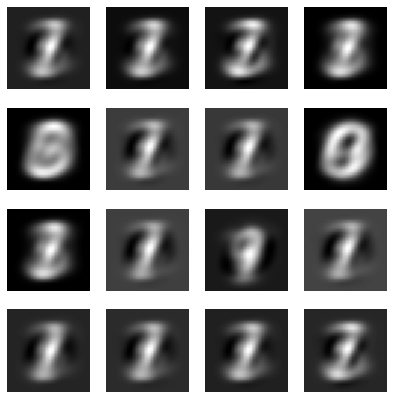

Generator Loss: 0.14390166552969977
Discriminator Loss: 2.1472223480146186
--------------------
[0.3738614478968211, 0.1568740837782643]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

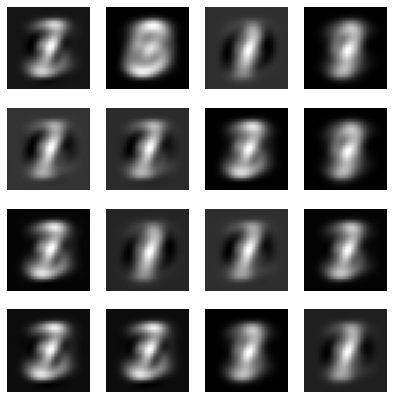

Generator Loss: 0.14495666885928107
Discriminator Loss: 2.0551801635210825
--------------------
[0.3973043033565122, 0.18182185519215355]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

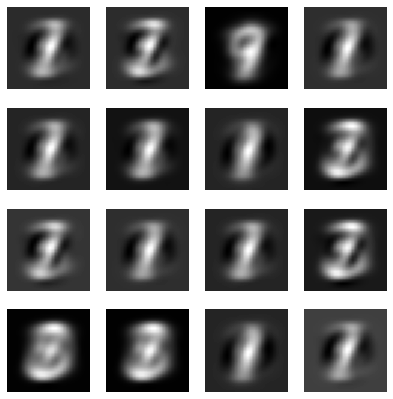

Generator Loss: 0.14053012935298614
Discriminator Loss: 2.1183853011883196
--------------------
[0.4006318700810568, 0.16384650943332718]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

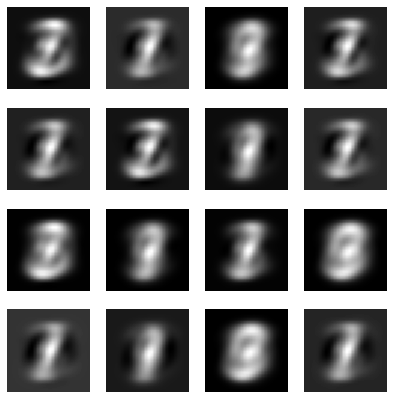

Generator Loss: 0.13988884949528888
Discriminator Loss: 2.1957546182556396
--------------------
[0.4193000200184123, 0.18677239320698608]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

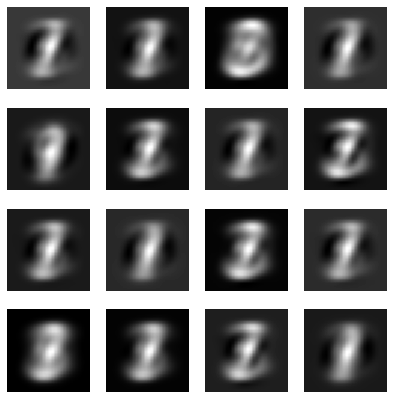

Generator Loss: 0.13846904457141077
Discriminator Loss: 2.116175901971738
--------------------
[0.4477087850387388, 0.1551319192532669]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

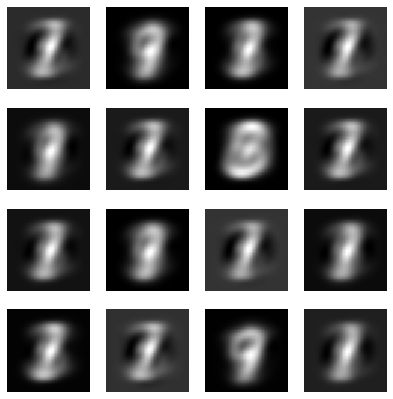

Generator Loss: 0.13642739603688167
Discriminator Loss: 2.2216910554969074
--------------------
[0.4326519516627509, 0.16743514773661702]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

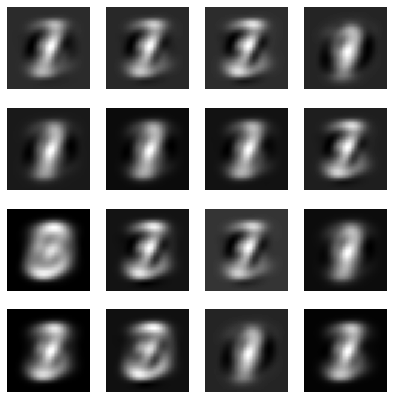

Generator Loss: 0.13521184563385016
Discriminator Loss: 2.2357611853427963
--------------------
[0.4212312862768691, 0.179548821963056]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

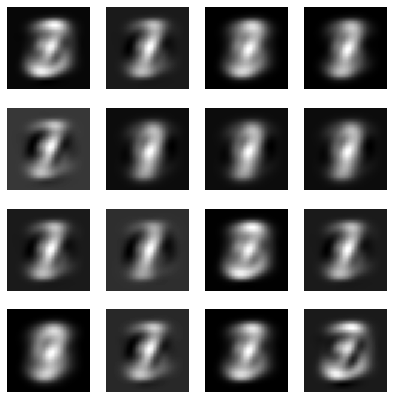

Generator Loss: 0.1334419076249109
Discriminator Loss: 2.2622065888010896
--------------------
[0.4122824577396926, 0.15115844614724164]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

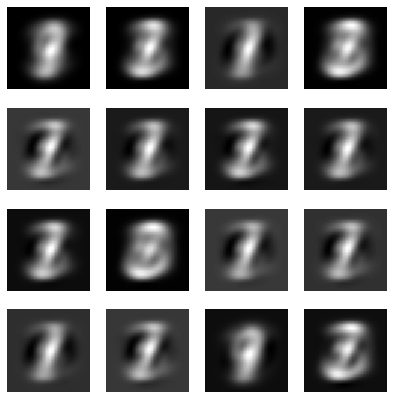

Generator Loss: 0.1308183550990491
Discriminator Loss: 2.2556434935108403
--------------------
[0.4673203780404528, 0.17155032439629564]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

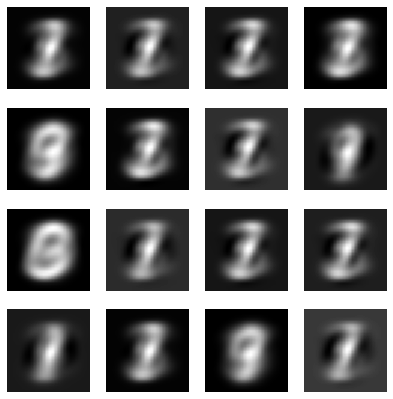

Generator Loss: 0.1302368278717129
Discriminator Loss: 2.2576882121117623
--------------------
[0.43442810912084745, 0.14092589448278464]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

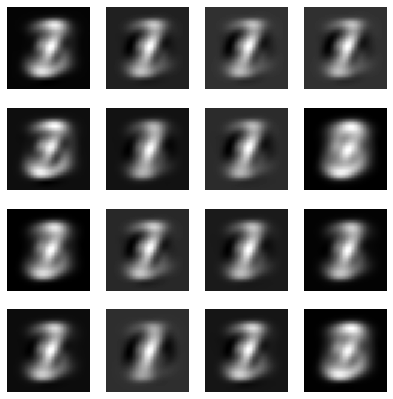

Generator Loss: 0.1268919656648228
Discriminator Loss: 2.1623738602605695
--------------------
[0.4203910989795037, 0.14927755921566296]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

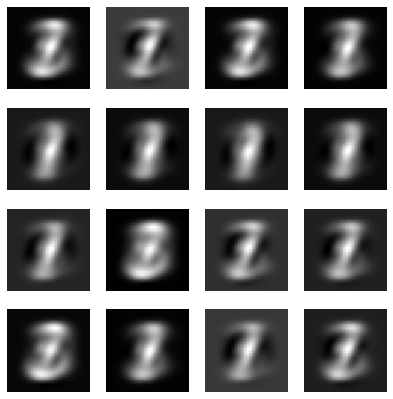

Generator Loss: 0.12499223404512715
Discriminator Loss: 2.2111456676305594
--------------------
[0.4204571148378269, 0.18859250931684016]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

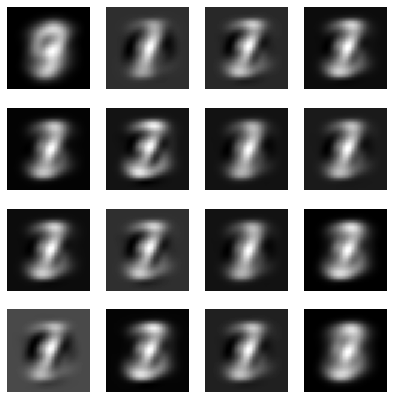

Generator Loss: 0.12347795973607935
Discriminator Loss: 2.2853331669526242
--------------------
[0.4467901390214927, 0.1700680549555342]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

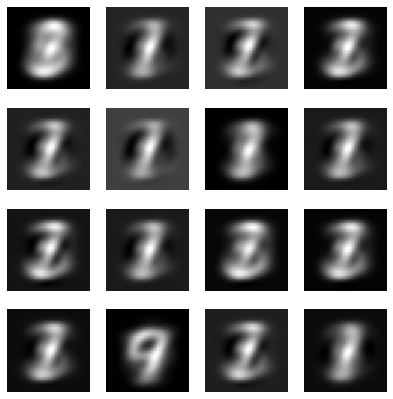

Generator Loss: 0.12235651483960866
Discriminator Loss: 2.3302095592702576
--------------------
[0.418118859761002, 0.14014357394336047]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

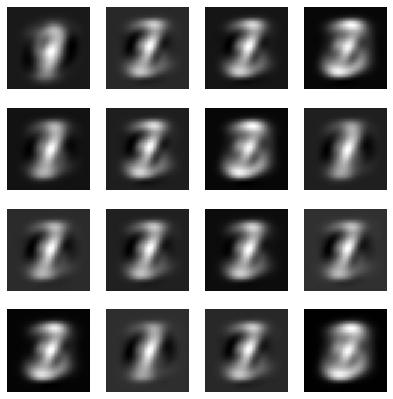

Generator Loss: 0.12197156834655504
Discriminator Loss: 2.298935759917471
--------------------
[0.45662425946689633, 0.13061555377566444]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

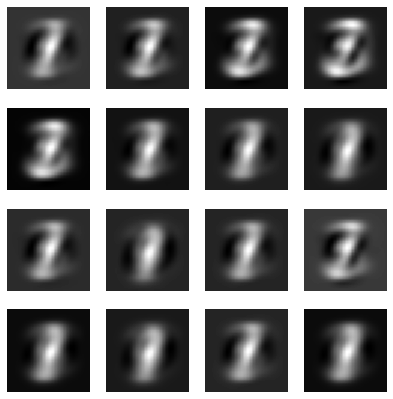

Generator Loss: 0.11878222799057875
Discriminator Loss: 2.3018237828641577
--------------------
[0.4332508968861062, 0.1641304051780793]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

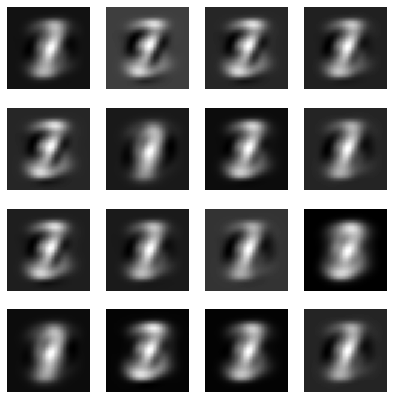

Generator Loss: 0.1174360411760498
Discriminator Loss: 2.3979688755069826
--------------------
[0.43141069836309376, 0.11618150817328594]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

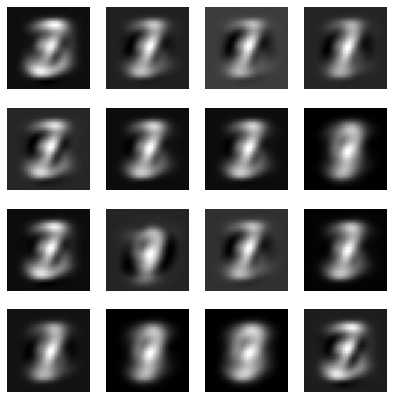

Generator Loss: 0.11609446783812599
Discriminator Loss: 2.2466373672968674
--------------------
[0.4166902643800204, 0.13702825302020546]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

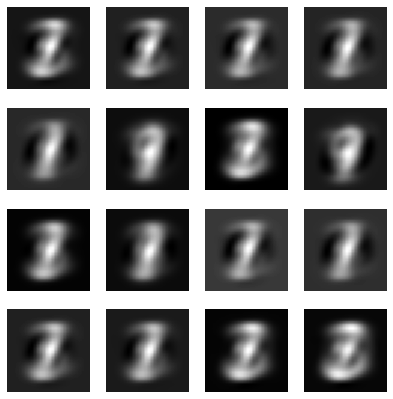

Generator Loss: 0.11396479211556612
Discriminator Loss: 2.3637322513089005
--------------------
[0.4599979650336979, 0.12857615806885225]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

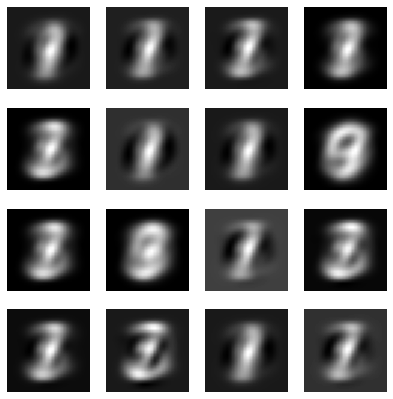

Generator Loss: 0.11376468556702542
Discriminator Loss: 2.3542304493481376
--------------------
[0.43822436829447053, 0.14260628915572973]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

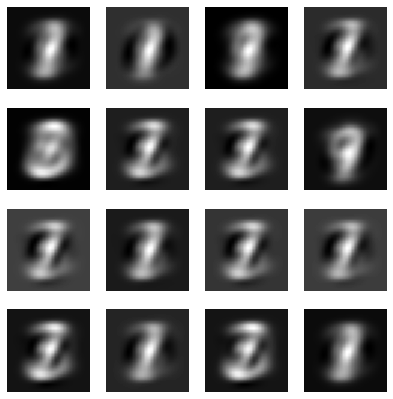

Generator Loss: 0.11041864351290553
Discriminator Loss: 2.4510813890223972
--------------------
[0.43664161839504867, 0.11960576486769636]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

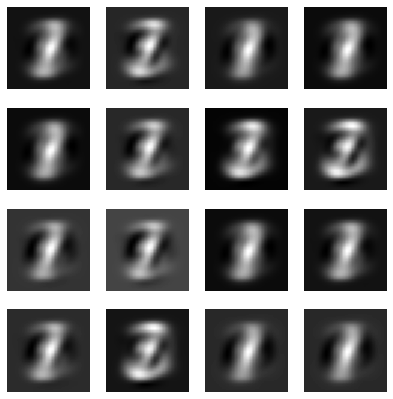

Generator Loss: 0.10835721187062566
Discriminator Loss: 2.307139448343758
--------------------
[0.4409500077983474, 0.1165977624394958]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

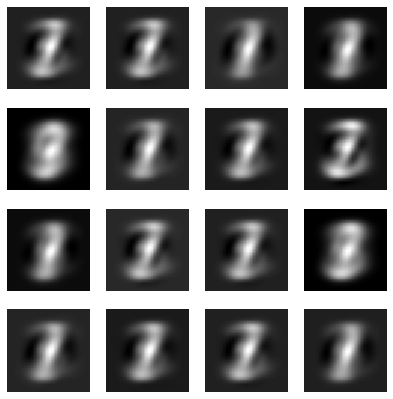

Generator Loss: 0.1080126081669369
Discriminator Loss: 2.400025059184137
--------------------
[0.43582388568739994, 0.13261460470075023]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

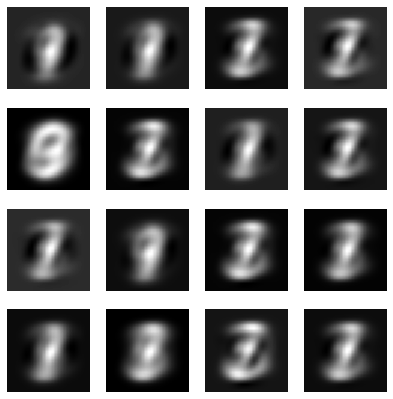

Generator Loss: 0.10799797955605649
Discriminator Loss: 2.475864771056495
--------------------
[0.46888573633447145, 0.12419284067858001]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

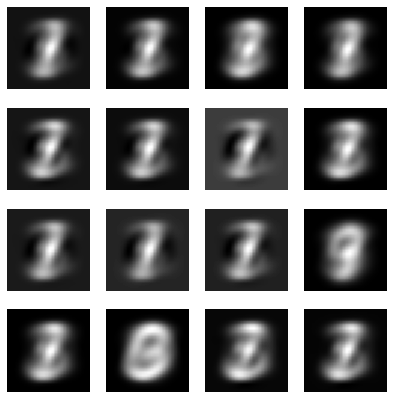

Generator Loss: 0.10431801650902493
Discriminator Loss: 2.4877452347610154
--------------------
[0.46027072284312887, 0.1218978213473744]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

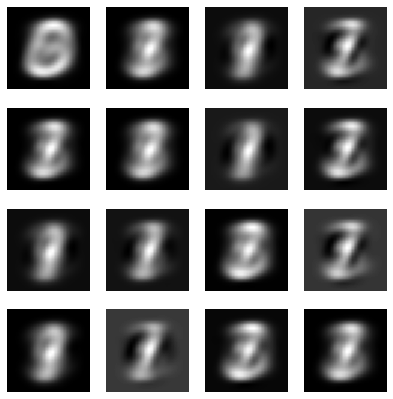

Generator Loss: 0.1038722590724524
Discriminator Loss: 2.4416816567826403
--------------------
[0.45868726399971527, 0.12229262193785224]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

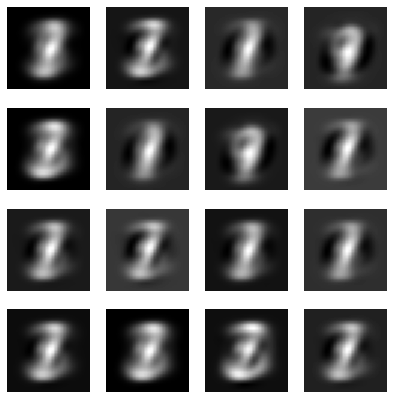

Generator Loss: 0.10292004846087958
Discriminator Loss: 2.439906974739931
--------------------
[0.45955166526331437, 0.12128553961363268]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

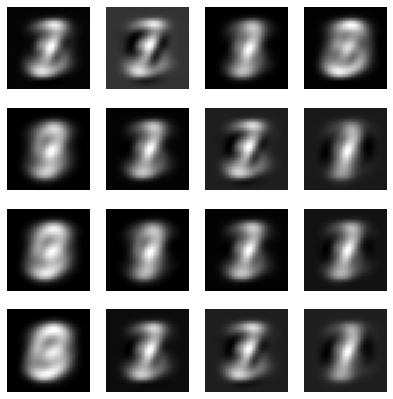

Generator Loss: 0.10036661611646232
Discriminator Loss: 2.5209679942067673
--------------------
[0.46363037531790785, 0.1395151359057412]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

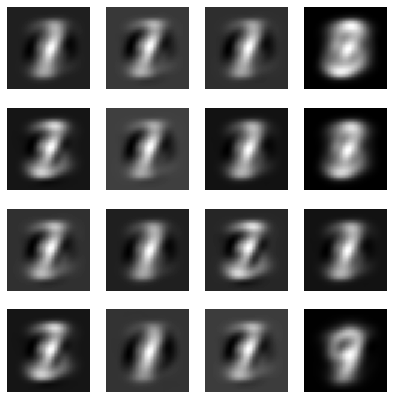

Generator Loss: 0.10003285652343073
Discriminator Loss: 2.449510471623174
--------------------
[0.45400518966059406, 0.10744533960772314]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

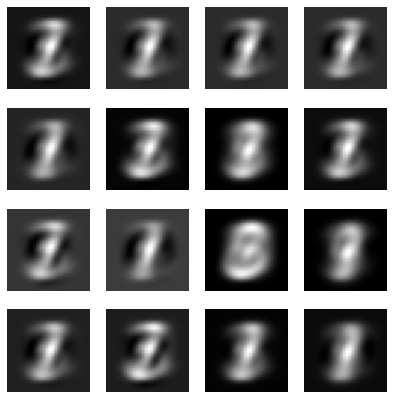

Generator Loss: 0.09942297990241733
Discriminator Loss: 2.47172353022975
--------------------
[0.4062825258833798, 0.14612668419392613]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

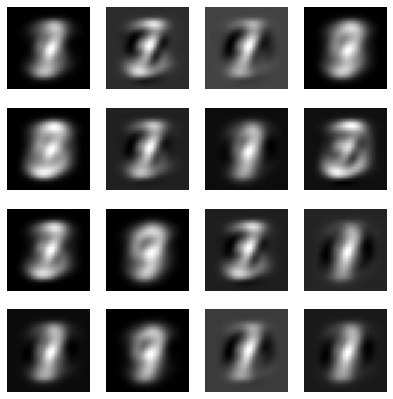

Generator Loss: 0.09612815140956063
Discriminator Loss: 2.4988004836381377
--------------------
[0.4529024037282754, 0.10495097618862438]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

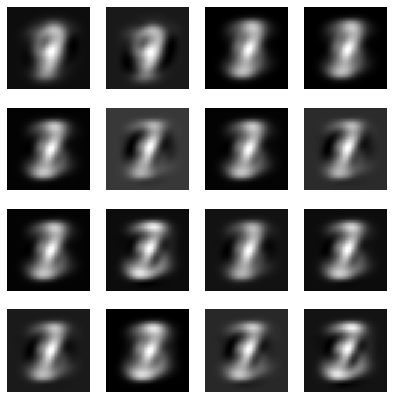

Generator Loss: 0.09498015298826566
Discriminator Loss: 2.509760811426716
--------------------
[0.44981075106818635, 0.10879441024678395]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

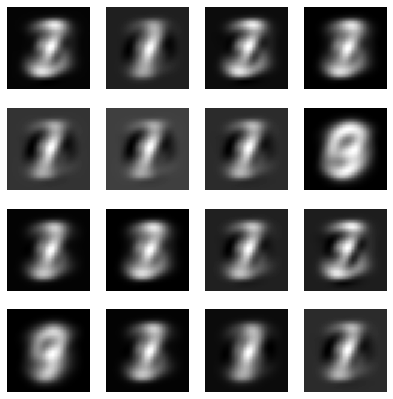

Generator Loss: 0.09455502676675641
Discriminator Loss: 2.526729144641839
--------------------
[0.4646818100531789, 0.08880486483687978]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

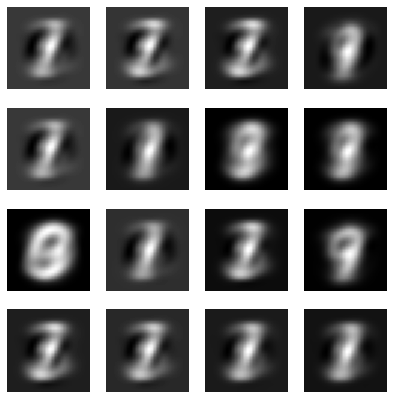

Generator Loss: 0.093730228901233
Discriminator Loss: 2.599803693927007
--------------------
[0.44824325815357946, 0.1056014327820211]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272711

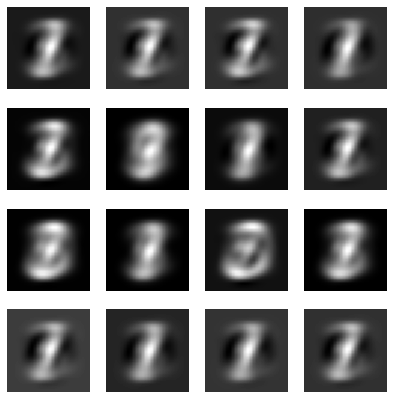

Generator Loss: 0.09273021559640889
Discriminator Loss: 2.472752965922639
--------------------
[0.43694512117636924, 0.15062091007247988]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

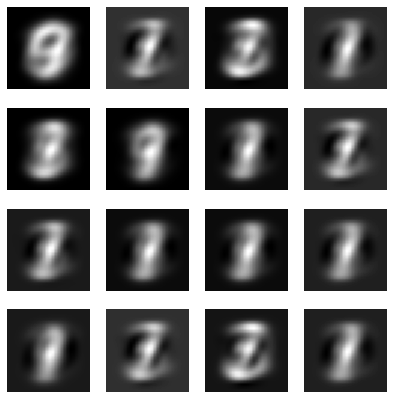

Generator Loss: 0.09097239884291129
Discriminator Loss: 2.6039410280470703
--------------------
[0.44334976691387035, 0.12034062337193477]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27

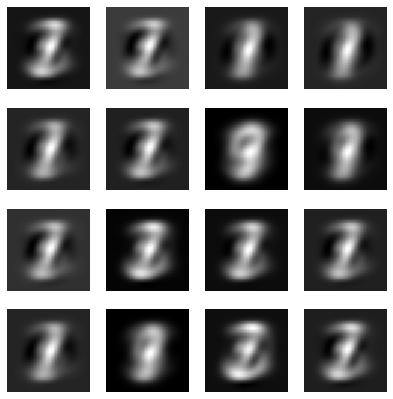

Generator Loss: 0.0900471530876873
Discriminator Loss: 2.515590212335332
--------------------
[0.45010223400610244, 0.11117608713644567]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

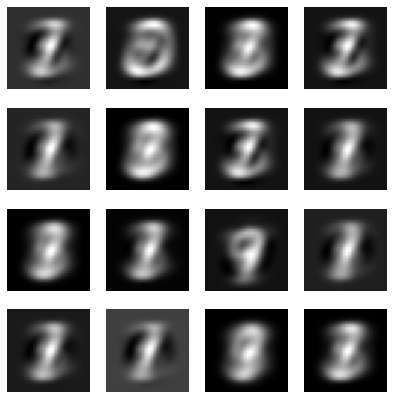

Generator Loss: 0.08854891660067608
Discriminator Loss: 2.563530204935013
--------------------
[0.4538285420417649, 0.11076308521618976]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.2727

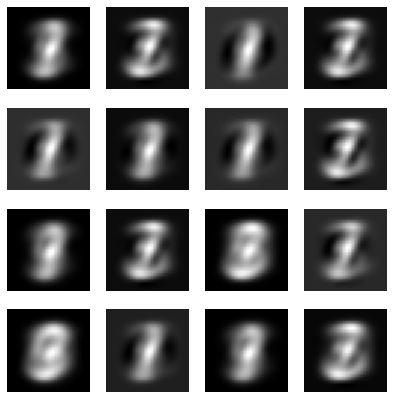

Generator Loss: 0.08700339698487844
Discriminator Loss: 2.609114601082846
--------------------
[0.44722379760739805, 0.07687865581295703]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

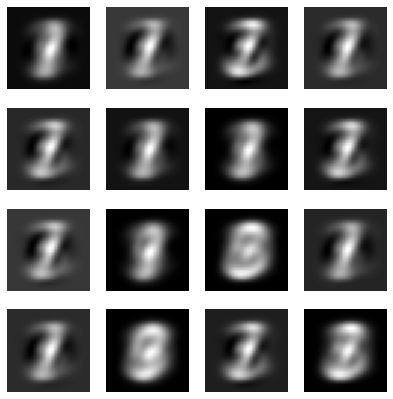

Generator Loss: 0.0856407125587382
Discriminator Loss: 2.6193165081505896
--------------------
[0.4314933259975727, 0.1192224461828769]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.27271

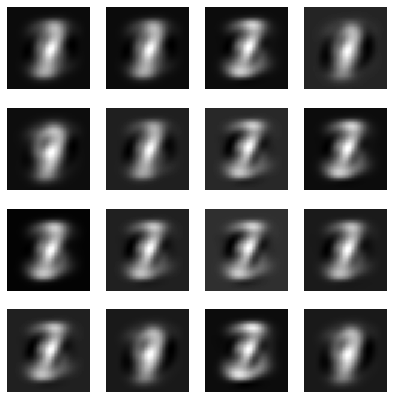

Generator Loss: 0.08405184092476353
Discriminator Loss: 2.627252086512645
--------------------
[0.44546864290845717, 0.11007622357916669]
[0.41929698046862396, 0.4460118534799793, 0.4265305543869512, 0.4192846931929606, 0.4112066493302994, 0.391729744808463, 0.4215022260374951, 0.40420226075285515, 0.37398402175646994, 0.36871800455108694, 0.3736857905024982, 0.36245105662596205, 0.35166658026050396, 0.35859913095160223, 0.34321826427985436, 0.313008953576434, 0.31402892917822905, 0.314246853531441, 0.3128613404953211, 0.3064488230814309, 0.2998625042920851, 0.269870487531465, 0.25061140568589757, 0.27494901639408226, 0.2738526831713975, 0.25113691734115234, 0.24445364414754317, 0.2435746298742221, 0.2327496773904988, 0.22500735014479886, 0.21803200110365425, 0.19585677143102168, 0.24379249263654895, 0.21932365185022, 0.21647401797491303, 0.23019389734422727, 0.21462447546490354, 0.22852626200603918, 0.22321241335429468, 0.2212626593965702, 0.2274167848085829, 0.2428946892064736, 0.272

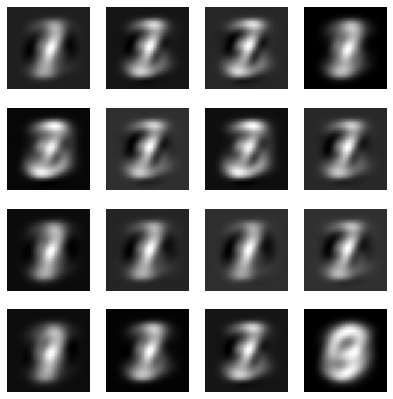

In [7]:
q=5 # Set it to dimensionality of data *n 2 +. 1
c=1
tracked_kl_div_1 = []
tracked_kl_div_2 = []
# Initialize a quantum circuit with q qubits, and c cbits
# Initializt Ancilla qubit in equi-superposition
circ = QuantumCircuit(q,c)
circ.h(0)
layer_style = "Controlled-Dual"
train_var = init_random_variables(q-1,layer_style)

# Initial Learning Settings such as alpha etc.
tracked_d_loss = []
gradients = []
learning_rate=0.0005
train_iter = 250
tracked_g_loss = []
gradients_g = []
corr = 0
wrong= 0 
loss_d_to_g = 0
loss_d_to_real = 0
tracked_loss_d_to_g = []
tracked_loss_d_to_real = []
train_on_fake = 5
df = [0,0]
print('Starting Training')
print('-'*20)

for epoch in np.arange(1,120):
    par_shift = 0.5*np.pi*np.sqrt(1/(epoch+1))
    # ------------------------------------------------------------------------------------------
    # This section is the discriminator training section
    # Each data point is tested against a random number, of which it decidesa wheter to 
    # Train against discerning between fake or real 
    # This causes "unstable" loss functions, but not very "unstable". Just slightly inconsistent
    # ------------------------------------------------------------------------------------------
    counter = 0
    for _ in range(1):
        for key,value in train_var.items():
            if str(q//2 + 1 ) in key:
                break
            for key_value in range(len(value)):
                forward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=True)),1,None)
                backward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=False)),1,None)
                df = 0.5*(forward_diff-backward_diff)
                if abs(df)>1:
                    df = df/abs(df)
                #train_var[key][key_value] -= df*learning_rate/10
    for index,point in enumerate(pca_data_rot):
        df = [0,0]
        gradients = []
        loss= [0,0]
        #Training the Discriminator:
        for key,value in train_var.items():
            if str(q//2 + 1) in key:
                break
            for key_value in range(len(value)):
                #TRAIN ON REAL DATA
                # BETIS HERE
                # _________
                forward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=True,fwd_diff=True)),0,None)
                backward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=True,fwd_diff=False)),0,None)
                df = 0.5*(forward_diff-backward_diff)
                train_var[key][key_value] -= learning_rate*df
        loss[0] += cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=False,fwd_diff=False)),0,None)
        loss[1] += 1
    loss_g = [0,0]
    # ------------------------------------------------------------------------------------------
    # This section is the generator training section
    # The discriminator just looks to fool the state we learnt above 
    # This means that instead of learning 10000 times, we could up the learning rate and just learn a few more times
    # We dont want it to be too large so it spins around the qubits state
    # ------------------------------------------------------------------------------------------
    #Train the generator now as much as we trained the Disc
    for _ in range(len(pca_data_rot)//10):
        gen_params=True
        for key,value in train_var.items():
            if str(q//2 + 1) not in key and gen_params:
                #print(f"{key} is not a GAN parameter")
                continue
            else: 
                gen_params = False
            for key_value in range(len(value)):
                #TRAIN ON FAKE DATA
                forward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=True)))
                backward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=False)))
                df = 0.5*(forward_diff-backward_diff)
                train_var[key][key_value] -= df*learning_rate*2.5
        loss_g[0] += generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=False,fwd_diff=False)))
        loss_g[1] +=1
    print(f"Generator Loss: {loss_g[0]/loss_g[1]}")
    tracked_g_loss.append(loss_g[0]/loss_g[1])
    loss_qgan = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=False,fwd_diff=False)),1,None) 
    t_loss = loss_qgan + (loss[0]/loss[1])
    tracked_loss_d_to_real.append(loss[0]/loss[1])
    tracked_loss_d_to_g.append(loss_qgan)
    print(f"Discriminator Loss: {t_loss}")
    tracked_d_loss.append(t_loss)
    print("-"*20)
    data = []
    circ = disc_fake_training_circuit(train_var,point,key,key_value,Sample=True)
    n_results = q//2
    for _ in range(500):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
    data = np.array(data)
    try:
        graph = sns.jointplot(x=data[:,0],y=data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
        graph.x = pca_data[:,0]
        graph.y = pca_data[:,1]
        graph.plot_joint(plt.scatter, marker='o', c='r', s=5)
        #plt.show()
    except:
        pass
    plt.savefig("qgan_ICLR_-epoch-mnist-{}-generated-distribution".format(epoch))
    dim1_kl_div = generate_kl_divergence_hist(pca_data, data)
    print(dim1_kl_div)
    tracked_kl_div_1.append(np.mean(np.array(dim1_kl_div)))
    print(tracked_kl_div_1)
    # For accurate KL Div we need to usue higher shots
    data = []
    for _ in range(16):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
    data = np.array(data)
    new_info = descale_points(data[:16])
    new_info = new_info.reshape(new_info.shape[0],28,28)
    print(f"Epoch {epoch} Generated Images")
    for i in range(new_info.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(new_info[i, :, :], cmap='gray')
        plt.axis('off')
    plt.savefig("qgan_ICLR_-epoch-mnist-{}-generated-images".format(epoch))
    plt.show()
    with open('new_qgan_results_mnis_epoch_ICLR_{}.txt'.format(epoch), 'w') as file:
        file.write("Tracked KL Divergence\n")
        file.write(str(tracked_kl_div_1)+"\n")
        file.write("Loss Of Generator\n")
        file.write(str(tracked_g_loss)+"\n")
        file.write("Loss Of Discriminator\n")
        file.write(str(tracked_d_loss)+"\n")
    save_variables(train_var,epoch)